In [ ]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

INCLUDE_ONLY = ['12345']
ACTIVITIES = ['walk']
SAMPLING_RATE = 100
OVERLAP = 0.5
CHUNK_SIZE = 1  # in seconds

In [ ]:
def fetch_data_by_treatment(treatment_filter):
    data_raw, docs = [], []
    data_ref = db.collection("data").document(treatment_filter)

    for patient_id in INCLUDE_ONLY:
        subject_ref = data_ref.collection(patient_id)
        for activity in ACTIVITIES:
            activity_ref = subject_ref.document(activity)
            for phone_location in activity_ref.collections():
                for recording in phone_location.stream():
                    record = recording.to_dict()
                    if 'acceleration' not in record:
                        continue
                    df = pd.DataFrame(record['acceleration'])
                    if 'timestamp' not in df.columns:
                        continue
                        
                    timestamps = df['timestamp']
                    min_time = timestamps.min()
                    max_time = timestamps.max()

                    df = df[(timestamps >= min_time + 2500) & (timestamps <= max_time - 2500)]
                    if df.empty:
                        continue

                    combined = pd.DataFrame({
                        'time': df['timestamp'],
                        'ax': df['accelerometer'].apply(lambda x: x['x']),
                        'ay': df['accelerometer'].apply(lambda x: x['y']),
                        'az': df['accelerometer'].apply(lambda x: x['z']),
                        'gx': df['gyroscope'].apply(lambda x: x['x']),
                        'gy': df['gyroscope'].apply(lambda x: x['y']),
                        'gz': df['gyroscope'].apply(lambda x: x['z']),
                    })

                    data_raw.append(combined)
                    docs.append({
                        'patient': patient_id,
                        'activity': activity,
                        'treatment': treatment_filter,
                        'phone_location': phone_location.id  
                    })
    return data_raw, docs

In [ ]:
def visualize_data(docs, data_raw):
    for i in range(len(docs)):
        df = data_raw[i]
        patient = docs[i]['patient']
        activity = docs[i]['activity']
        treatment = docs[i]['treatment']
        phone_location = docs[i]['phone_location']

        fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

        # Accelerometer
        axs[0].plot(df["time"], df["ax"], label="Ax")
        axs[0].plot(df["time"], df["ay"], label="Ay")
        axs[0].plot(df["time"], df["az"], label="Az")
        axs[0].plot(df["time"], np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2),
                    label="Acc Magnitude", linestyle="--")
        axs[0].set_title(f"{treatment} | Patient XXXXX | {activity} | {phone_location} | Accelerometer")
        axs[0].set_ylabel("Acceleration (g)")
        axs[0].legend()

        # Gyroscope
        axs[1].plot(df["time"], df["gx"], label="Gx")
        axs[1].plot(df["time"], df["gy"], label="Gy")
        axs[1].plot(df["time"], df["gz"], label="Gz")
        axs[1].plot(df["time"], np.sqrt(df["gx"]**2 + df["gy"]**2 + df["gz"]**2),
                    label="Gyro Magnitude", linestyle="--")
        axs[1].set_title("Gyroscope")
        axs[1].set_xlabel("Time (ms)")
        axs[1].set_ylabel("Angular Velocity (rad/s)")
        axs[1].legend()

        plt.tight_layout()
        plt.show()

In [16]:
before_data, before_docs = fetch_data_by_treatment("BeforeTreatment")
after_data, after_docs   = fetch_data_by_treatment("AfterTreatment")
print(f"Fetched {len(before_data)} before-treatment and {len(after_data)} after-treatment recordings")

Fetched 4 before-treatment and 4 after-treatment recordings


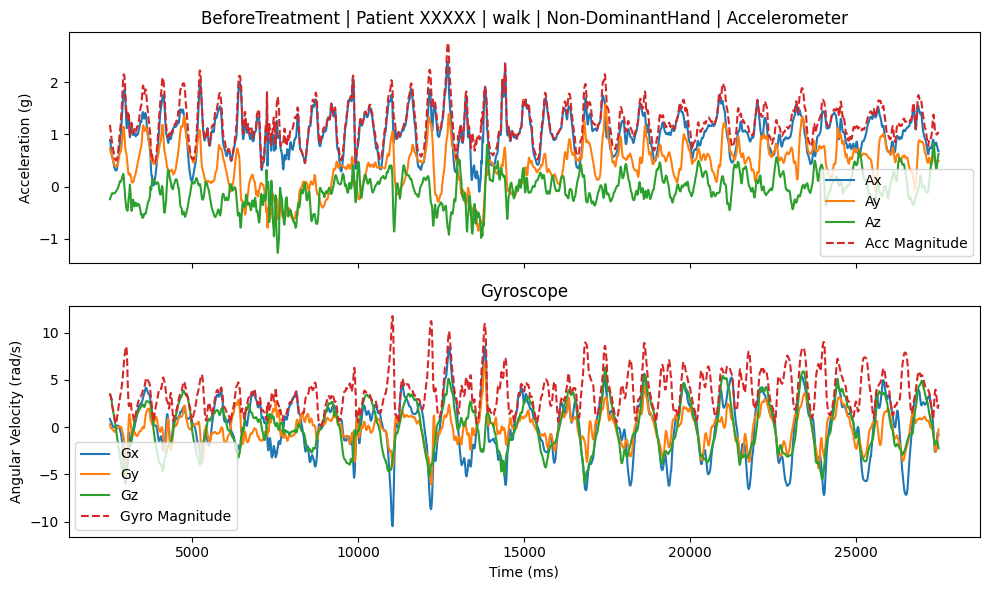

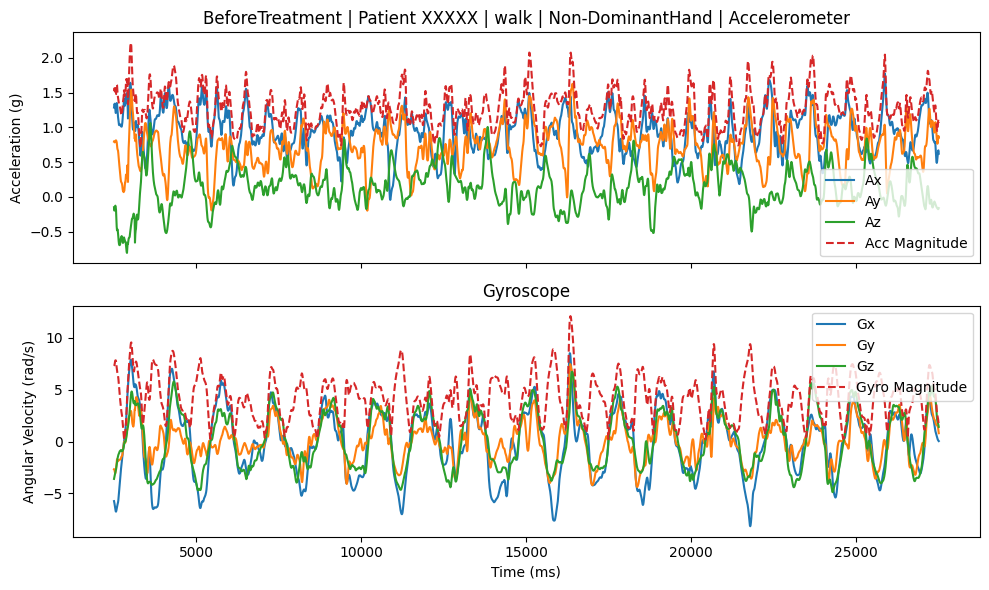

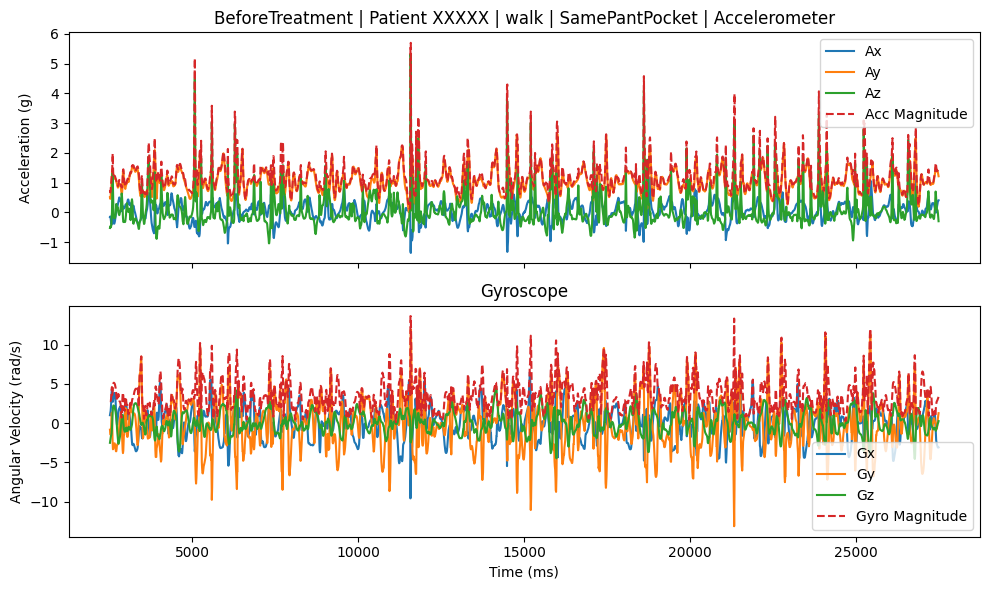

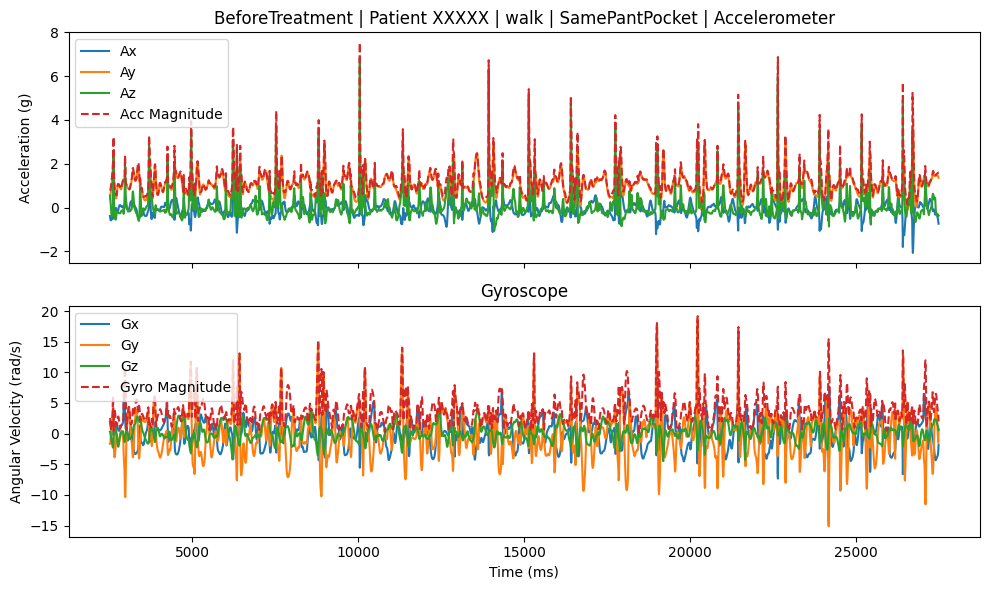

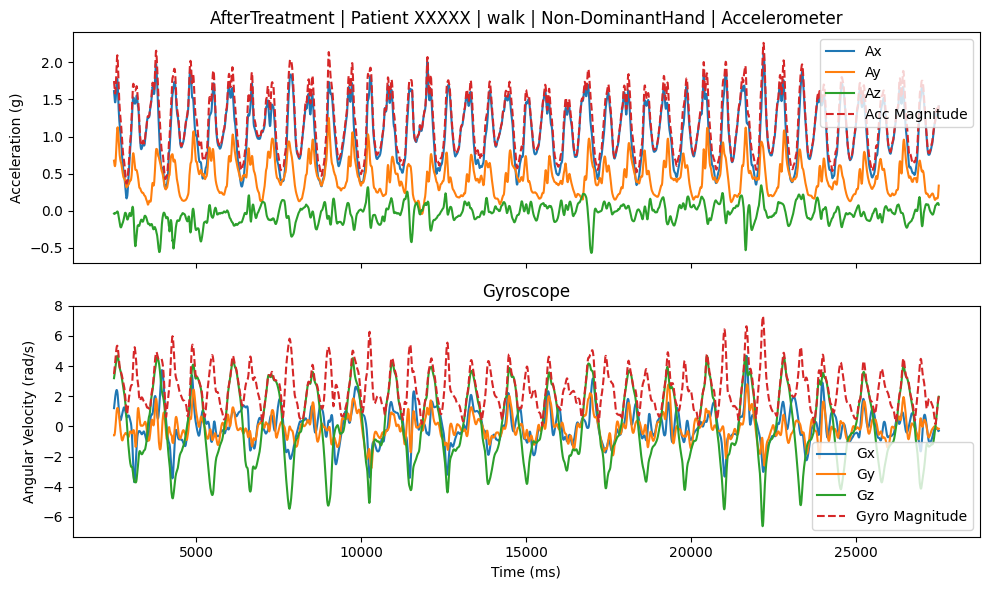

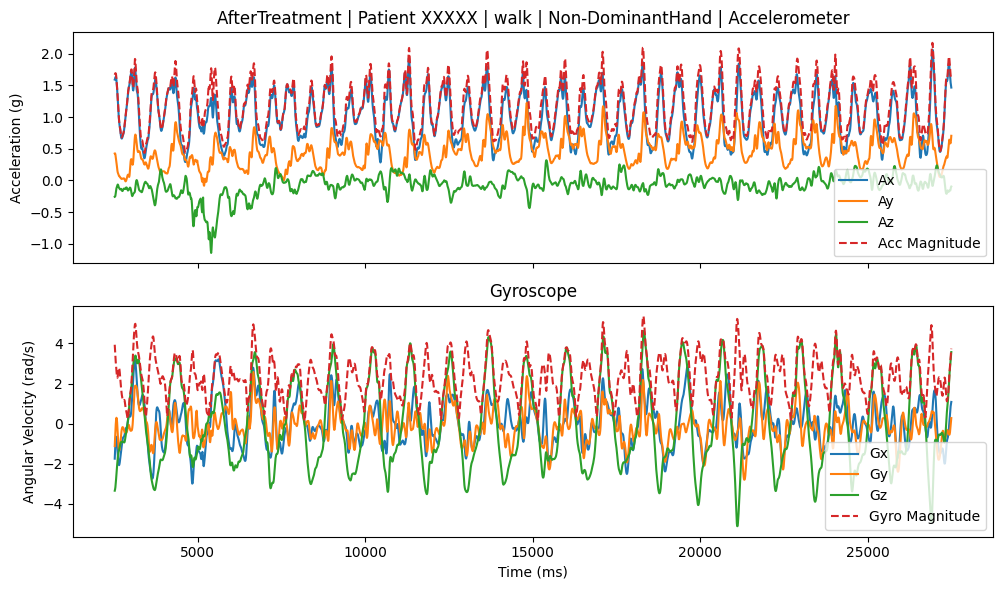

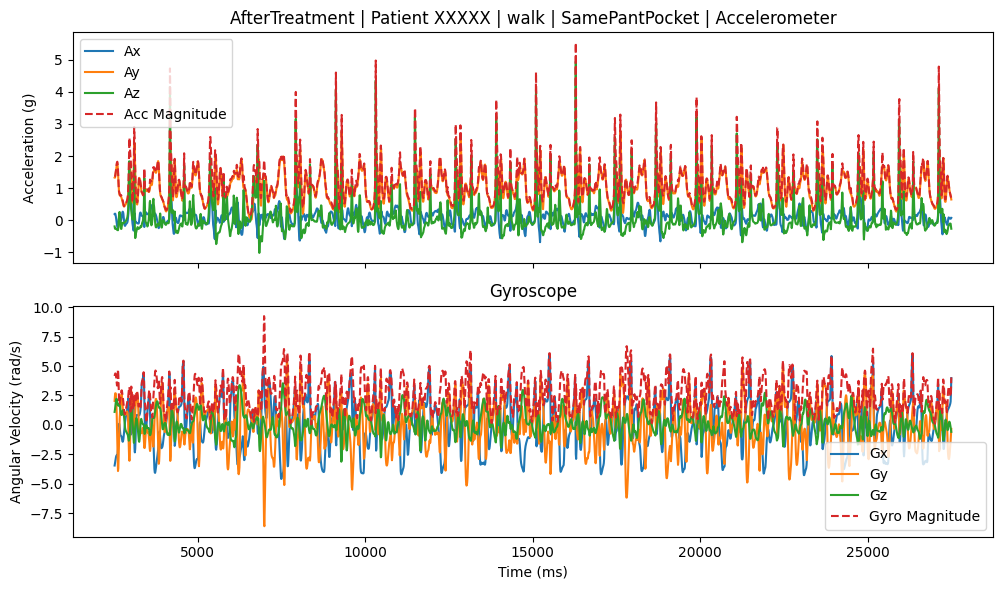

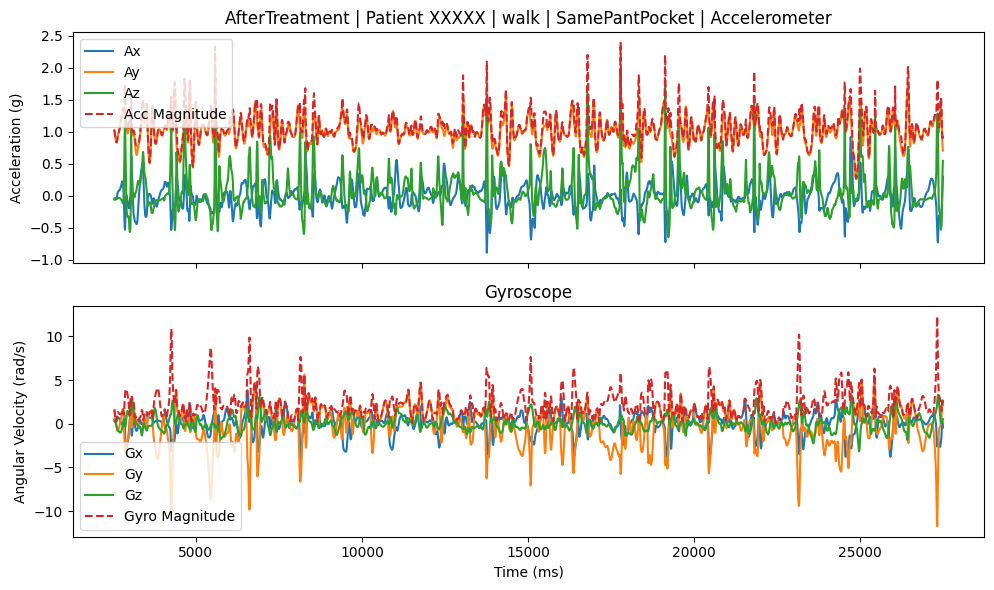

In [17]:
visualize_data(before_docs, before_data)
visualize_data(after_docs, after_data)